**Kerakli kutubxonalar**

In [8]:
!pip install jiwer
!pip install pydub
!pip install tensorflow
!pip install pandas

[Datasetni yuklab olish uchun havola](https://commonvoice.mozilla.org/en/datasets)

In [ ]:
!tar -xvzf "/content/drive/MyDrive/cv-corpus-17.0-2024-03-15-uz.tar.gz" -C "/content/drive/MyDrive/UzbekVoice/"  #Datasetni arxivdan chiqarish

**Audio fayllarni mp3 formatdan wav ga o'tkazish**

In [ ]:
import os
import threading
from pydub import AudioSegment
import pandas as pd

def mp3_to_wav(mp3_file, wav_file):
    sound = AudioSegment.from_mp3(mp3_file)
    sound.export(wav_file, format="wav")


def convert_mp3_to_wav(input_directory, output_directory, mp3_files):
    jobs = []
    for mp3_file in mp3_files:
        input_path = os.path.join(input_directory, mp3_file)
        output_path = os.path.join(output_directory, os.path.splitext(mp3_file)[0] + ".wav")
        t = threading.Thread(target=mp3_to_wav, args=(input_path, output_path))
        jobs.append(t)
        t.start()

    for job in jobs:
        job.join()


df = pd.read_csv("/content/drive/MyDrive/UzbekVoice/cv-corpus-17.0-2024-03-15-uz/uz/train.csv",sep="\t")

mp3_files = df.path.to_list()

directory = "/content/drive/MyDrive/UzbekVoice/cv-corpus-17.0-2024-03-15-uz/uz/clips"

out_directory = "/content/drive/MyDrive/Audio/"

convert_mp3_to_wav(directory, out_directory, mp3_files)

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import math 
import re

In [10]:
metadata_df=pd.read_csv('wavs.csv')
wavs_path='wav/'
metadata_df


,file_name,normalized_transcription
0,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/80347655f...,batareyasining quvvati esa bir oygacha yetadi
1,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/80f2e9081...,indoneziyada halokatga uchragan samolyotning b...
2,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/7f396a0e6...,"janobi oliylari, samimiy ehtiromlarimni qabul ..."
3,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/7f1eea474...,singapurda o'smirlar o'rtasidagi olimpiada och...
4,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/86d3d79fa...,ularning avtomobillari noma'lum shaxslar tomon...
...,...,...
11706,4360f317-309d-4a17-9377-4c3ff597d95c/4eb6a8ab6...,"qolaversa, tadbirkorlik sub'ektlari ulgurji sa..."
11707,4360f317-309d-4a17-9377-4c3ff597d95c/4dd1863d7...,to'kilib tushadi sal shamol tegsa
11708,4360f317-309d-4a17-9377-4c3ff597d95c/4eae70fa8...,rossiyadagi yurtdoshlarimiz haydovchilik guvoh...
11709,4360f317-309d-4a17-9377-4c3ff597d95c/573414bab...,"g'amlar yuboribsan, demak, dunyoda"


**Sonlarni satr ko'rinishiga  va matnlarni kichik casega o'tkazish**

In [11]:
class IntegerPronunciation:
    def __init__(self):
        self.ONES = ['', 'bir', 'ikki', 'uch', 'to\'rt', 'besh', 'olti', 'yetti', 'sakkiz', 'to\'qqiz']
        self.TWOS = ['', 'o\'n', 'yigirma', 'o\'ttiz', 'qirq', 'ellik', 'oltmish', 'yetmish', 'sakson', 'to\'qson']
        self.OTHERS = ['', '', 'ming', 'million', 'milliard', 'trillion']

    def son_to_str(self, son):
        l = len(son)
        if l == 1:
            return self.ONES[int(son)]
        if l == 2:
            return f"{self.TWOS[int(son[0])]} {self.son_to_str(son[1])}"
        if l == 3:
            if son[0] == '0':
                return self.son_to_str(son[1:])
            return f"{self.son_to_str(son[0])} yuz {self.son_to_str(son[1:])}"
        if l > 3:
            if son[0] == '0':
                return self.son_to_str(son[1:])
            s = math.ceil(l/3)
            n = (s-1)*3
            return f"{self.son_to_str(son[:-n])} {self.OTHERS[s]} {self.son_to_str(son[-n:])}"

    def main(self, son):
        if '-' in son:
            son = son.replace('-', '').strip()
            result = self.son_to_str(str(son)).replace('  ', ' ').strip()
            if son[-1] in '267':
                result += 'nchi'
            else:
                result += 'inchi'
        else:
            result = self.son_to_str(str(son)).replace(' ', ' ')
        return result

son_ = IntegerPronunciation()

def num2word(text):
    numbers = re.findall(r'\d+', text)

    for num in numbers:
        word_rep = son_.main(num)
        text = text.replace(num, word_rep)
    return text

    
def clean_string(input_string):
    cleaned_string = re.sub(r'[^a-z\' ]', '', input_string)
    return cleaned_string


metadata_df["normalized_transcription"] = metadata_df["normalized_transcription"].str.lower()
metadata_df["normalized_transcription"] = metadata_df["normalized_transcription"].apply(lambda x:clean_string(x))
metadata_df['normalized_transcription'] = metadata_df['normalized_transcription'].apply(lambda x: num2word(x))
metadata_df.head(5)

,file_name,normalized_transcription
0,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/80347655f...,batareyasining quvvati esa bir oygacha yetadi
1,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/80f2e9081...,indoneziyada halokatga uchragan samolyotning b...
2,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/7f396a0e6...,janobi oliylari samimiy ehtiromlarimni qabul q...
3,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/7f1eea474...,singapurda o'smirlar o'rtasidagi olimpiada och...
4,4c6eb13d-eb9a-4b9b-8b2f-16adfa09a38f/86d3d79fa...,ularning avtomobillari noma'lum shaxslar tomon...


In [12]:
split = int(len(metadata_df) * 0.90) #Datasetni train va test ga ajratish
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 10539
Size of the training set: 1172


In [13]:

characters = [x for x in """abcdefghijklmnopqrstuvwxyz' """] #Satrlarni tokenlarga ajratish
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}\n "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' ']
 (size =29)


In [14]:

frame_length = 256
frame_step = 160
fft_length = 384


def encoder(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label


In [15]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encoder, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encoder, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


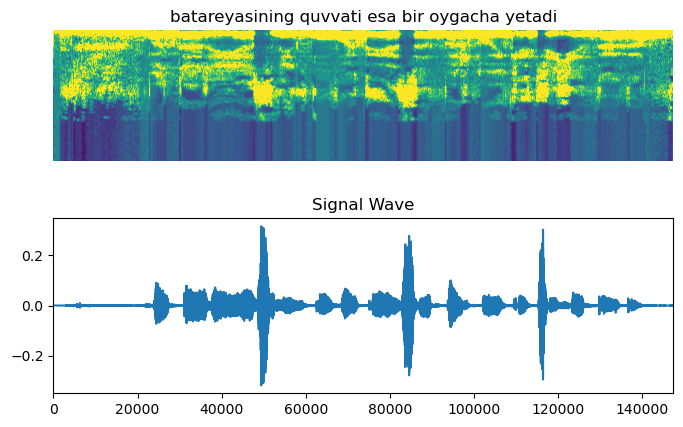

In [16]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    file = tf.io.read_file(str(wavs_path + (df_train["file_name"].loc[0])))
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


In [17]:
def CTCLoss(y_true, y_pred):
    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [18]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [19]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    
    return model


with strategy.scope():
    model = build_model(
        input_dim=fft_length // 2 + 1,
        output_dim=char_to_num.vocabulary_size(),
        rnn_units=512,
    )
model.summary(line_length=110)


Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [20]:

def decoder(pred):
    
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


class CallbackEval(keras.callbacks.Callback):

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decoder(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [47]:

epochs = 10

validation_callback = CallbackEval(validation_dataset)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


Epoch 1/10
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : endi xorijliklar shifo izlab qarshiga kelishi mumkin
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : samimiy insonlari menda katta taassurot qoldirdi
Prediction: 
----------------------------------------------------------------------------------------------------
330/330 [==============================] - 533s 2s/step - loss: 181.1589 - val_loss: 202.1517
Epoch 2/10
1/1 [==============================] - 0s 405ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------

In [48]:
model.save("model.h5")

In [49]:

epochs = 10

validation_callback = CallbackEval(validation_dataset)

history2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


Epoch 1/10
1/1 [==============================] - 0s 402ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9040
----------------------------------------------------------------------------------------------------
Target    : biroq kutilmagan sabab tufayli sportchi bahslarda ishtirok eta olmaydigan bo'ldi
Prediction: bro tulmagan savabtvanini sforchila bahslardi isyon etormaydigan bo'ldi
----------------------------------------------------------------------------------------------------
Target    : u shunday baxtliki qalbim qo'shiq kuylayotganga o'xshaydi
Prediction: ushuda vaqnigi qalbumoshi iniotkanga oshidi
----------------------------------------------------------------------------------------------------
330/330 [==============================] - 500s 2s/step - loss: 58.2517 - val_loss: 62.9972
Epoch 2/10
1/1 [==============================] - 0s 401ms/step
-------------------------------------------------

In [50]:
model.save("model_2.h5")

In [23]:
import keras

reloaded_model = keras.models.load_model("model.h5", compile=False)

frame_length = 256
frame_step = 160
fft_length = 384

characters = [x for x in """abcdefghijklmnopqrstuvwxyz' """]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

def preprocess_audio(audio_file_path):
    file = tf.io.read_file(audio_file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    return spectrogram


def predict_transcription(audio_file_path):
    spectrogram = preprocess_audio(audio_file_path)
    prediction = reloaded_model.predict(tf.expand_dims(spectrogram, 0))
    transcription = decoder(prediction)[0]
    return transcription

# Test with WAV audio data
wav_file_path = "12ab0eed-4eec-4c0a-922e-cf588e026203/01e7b08a2e518db36a7dc43d9ad60d496534b6a813b232bf8fb8e53b3666ee61.wav"
transcription = predict_transcription(wav_file_path)
print("Predicted Transcription:", transcription)

1/1 [==============================] - 3s 3s/step
Predicted Transcription: rasman shavtiyat mirziyoyev belarusgaa tashrifumran
